## PART 1 : Import necessary functions, set parameters and load your own recordings ##

#### Import librairies, custom functions and set repository folder ####

In [1]:
# Importation of librairies and functions
import os
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# check some package versions for documentation and reproducibility
import sys
import mne
from matplotlib import __version__ as plt_version
import scipy
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('mne', mne.__version__)
print('sci-py', scipy.__version__)
print('matplotlib', plt_version)

Python sys 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:14:58) [MSC v.1929 64 bit (AMD64)]
pandas 1.5.3
numpy 1.23.5
mne 1.3.0
sci-py 1.10.0
matplotlib 3.6.3


In [3]:
def set_cd_repo_folder():
    """sets current working directory to main repo folder"""
    cd = os.getcwd()

    check = 0

    while os.path.basename(cd) != 'ReSync':

        cd = os.path.dirname(cd)
        check += 1
        if check > 10: raise ValueError('Repo path not found')
    
    os.chdir(cd)

    print(f'working directory changed to {os.getcwd()}')

    return os.getcwd()


In [4]:
project_path = set_cd_repo_folder()

working directory changed to c:\Users\Juliette\Research\Projects\Synchronization_project\Code\ReSync


In [5]:
# import custom-made functions
import functions.preprocessing as preproc
import functions.utils as utils
import functions.plotting as plot
import functions.find_artefacts_dev as artefact
import functions.crop as crop
import functions.main_resync as resync
#import functions.plotting_interactive as plot_interact

In [6]:
importlib.reload(plot)
importlib.reload(preproc)
importlib.reload(utils)
importlib.reload(artefact)
importlib.reload(crop)
importlib.reload(resync)
#importlib.reload(plot_interact)

<module 'functions.main_resync' from 'c:\\Users\\Juliette\\Research\\Projects\\Synchronization_project\\Code\\ReSync\\functions\\main_resync.py'>

#### Load your own LFP data: ####

Resulting variables needed for subsequent analysis:
- LFP_array (np.ndarray, 6d): the LFP recording which has to be aligned, containing all channels
- lfp_sig (np.ndarray, 1d): the channel containing the LFP signal from the hemisphere where the stimulation was delivered to create artefacts
- LFP_rec_ch_names (list): names of all the channels, in a list (will be used to annotate cropped recording)


In [8]:
# load pyPerceive functions
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.join(os.getcwd(), 'PyPerceive'))
os.chdir(os.path.join(os.getcwd(), 'code'))
pyPerceive_path = os.getcwd()
print (f'working dir to go fetch PyPerceive functions:{pyPerceive_path}')

from PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class
)
import PerceiveImport.methods.load_rawfile as load_rawfile
import PerceiveImport.methods.find_folders as find_folders
import PerceiveImport.methods.metadata_helpers as metaHelpers

#reset the proper working directory for the analysis
os.chdir(project_path)
print (f'working dir set back to:{project_path}')

working dir to go fetch PyPerceive functions:c:\Users\Juliette\Research\Projects\Synchronization_project\Code\PyPerceive\code
working dir set back to:c:\Users\Juliette\Research\Projects\Synchronization_project\Code\ReSync


In [9]:
# choose LFP file
sub041 = main_class.PerceiveData(
    sub = "041", 
    incl_modalities=['streaming'],
    incl_session = ["fu18m"],
    incl_condition =['m0s0','m0s1','m1s0','m1s1'],
    incl_task = ["rest","fingerTap"],
    # incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
    allow_NaNs_in_metadata=False
)

# define LFP data
LFP_rec = sub041.streaming.fu18m.m1s0.rest.run1.data
LFP_array = LFP_rec.get_data()
ch_i = 0 #choose index of the channel containing the stim artefacts (O for left hemisphere, 1 for right hemisphere)
lfp_sig = LFP_rec.get_data()[ch_i]
LFP_rec_ch_names = LFP_rec.ch_names

n_chan = len(LFP_rec.ch_names)
time_duration_LFP = (LFP_rec.n_times/LFP_rec.info['sfreq']).astype(float)
print(     
	f'The data object has:\n\t{LFP_rec.n_times} time samples,'      
	f'\n\tand a sample frequency of {LFP_rec.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration_LFP} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{LFP_rec.ch_names}.')
print(f'The channel containing artefacts has index {ch_i} and is named {LFP_rec.ch_names[ch_i]}')


	### WARNING: NaNs in Metadata Table sub-041 ###
NaNs in: sub-20220404PStn_ses-2022071206564297_run-BrainSense20220712073400.mat
NaNs in: sub-20220404PStn_ses-2022071206564297_run-BrainSense20220712075100.mat
NaNs in: sub-20220404PStn_ses-2022071206564297_run-BrainSense20220712080900.mat
NaNs in: sub-20220404PStn_ses-2022071206564297_run-BrainSense20220712082700.mat
NaNs in: sub-20220404PStn_ses-2022071206564297_run-BrainSense20220712084400.mat
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=69063
    Range : 0 ... 69062 =      0.000 ...   276.248 secs
Ready.
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=78937
    Range : 0 ... 78936 =      0.000 ...   315.744 secs
Ready.
add run 2
Creating RawArray with float64 data, n_channels=6, n_times=107625
    Range : 0 ... 107624 =      0.000 ...   430.496 secs
Ready.
add run 3
Creating RawArray with float64 data, n_channels=6, n_times=27938
    Range : 0 ... 27937 =      0.000 ...   111.748 secs
Rea

In [119]:
# choose LFP file
sub055 = main_class.PerceiveData(
    sub = "055", 
    incl_modalities=['streaming'],
    incl_session = ["fu12m"],
    incl_condition =['m0s0','m0s1','m1s0','m1s1'],
    incl_task = ["rest","fingerTap"],
    # incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
    allow_NaNs_in_metadata=False
)

# define LFP data
LFP_rec = sub055.streaming.fu12m.m1s0.rest.run1.data
LFP_array = LFP_rec.get_data()
ch_i = 0 #choose index of the channel containing the stim artefacts (O for left hemisphere, 1 for right hemisphere)
lfp_sig = LFP_rec.get_data()[ch_i]
LFP_rec_ch_names = LFP_rec.ch_names

n_chan = len(LFP_rec.ch_names)
time_duration_LFP = (LFP_rec.n_times/LFP_rec.info['sfreq']).astype(float)
print(     
	f'The data object has:\n\t{LFP_rec.n_times} time samples,'      
	f'\n\tand a sample frequency of {LFP_rec.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration_LFP} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{LFP_rec.ch_names}.')
print(f'The channel containing artefacts has index {ch_i} and is named {LFP_rec.ch_names[ch_i]}')


	### WARNING: NaNs in Metadata Table sub-055 ###
NaNs in: sub-20220726PStn_ses-2022080107125699_run-BrainSense20220801072200.mat
NaNs in: sub-20220726PStn_ses-2022080107125699_run-BrainSense20220801074400.mat
NaNs in: sub-20220726PStn_ses-2022080107125699_run-BrainSense20220801074700.mat
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=75313
    Range : 0 ... 75312 =      0.000 ...   301.248 secs
Ready.
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=220000
    Range : 0 ... 219999 =      0.000 ...   879.996 secs
Ready.
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=76688
    Range : 0 ... 76687 =      0.000 ...   306.748 secs
Ready.
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=202375
    Range : 0 ... 202374 =      0.000 ...   809.496 secs
Ready.
The data object has:
	76688 time samples,
	and a sample frequency of 250.0 Hz
	with a recording duration of 306.752 seconds.
	6 channels were labeled as 


In [138]:
# choose LFP file
sub023 = main_class.PerceiveData(
    sub = "023", 
    incl_modalities=['streaming'],
    incl_session = ["fu18m"],
    incl_condition =['m0s0','m0s1','m1s0','m1s1'],
    incl_task = ["rest","fingerTap"],
    # incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
    allow_NaNs_in_metadata=False
)

# define LFP data
LFP_rec = sub023.streaming.fu18m.m1s0.rest.run1.data
LFP_array = LFP_rec.get_data()
ch_i = 0 #choose index of the channel containing the stim artefacts (O for left hemisphere, 1 for right hemisphere)
lfp_sig = LFP_rec.get_data()[ch_i]
LFP_rec_ch_names = LFP_rec.ch_names

n_chan = len(LFP_rec.ch_names)
time_duration_LFP = (LFP_rec.n_times/LFP_rec.info['sfreq']).astype(float)
print(     
	f'The data object has:\n\t{LFP_rec.n_times} time samples,'      
	f'\n\tand a sample frequency of {LFP_rec.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration_LFP} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{LFP_rec.ch_names}.')
print(f'The channel containing artefacts has index {ch_i} and is named {LFP_rec.ch_names[ch_i]}')


	### WARNING: NaNs in Metadata Table sub-023 ###
NaNs in: sub-20210608PStn_ses-2022080206582480_run-BrainSense20220802071600.mat
NaNs in: sub-20210608PStn_ses-2022080206582480_run-BrainSense20220802073500.mat
NaNs in: sub-20210608PStn_ses-2022080206582480_run-BrainSense20220802073800.mat
NaNs in: sub-20210608PStn_ses-2022080207424780_run-BrainSense20220802075000.mat
NaNs in: sub-20210608PStn_ses-2022080207424780_run-BrainSense20220802080000.mat
NaNs in: sub-20210608PStn_ses-2022080207424780_run-BrainSense20220802080300.mat
NaNs in: sub-20210608PStn_ses-2022080307160880_run-BrainSense20220803072600.mat
NaNs in: sub-20210608PStn_ses-2022080307160880_run-BrainSense20220803074100.mat
NaNs in: sub-20210608PStn_ses-2022080307160880_run-BrainSense20220803074300.mat
NaNs in: sub-20210608PStn_ses-2022080307160880_run-BrainSense20220803074900.mat
NaNs in: sub-20210608PStn_ses-2022080307160880_run-BrainSense20220803075200.mat
NaNs in: sub-20210608PStn_ses-2022080307160880_run-BrainSense202208030

In [145]:
# choose LFP file
sub041 = main_class.PerceiveData(
    sub = "041", 
    incl_modalities=['streaming'],
    incl_session = ["fu18m"],
    incl_condition =['m0s0','m0s1','m1s0','m1s1'],
    incl_task = ["rest","fingerTap"],
    # incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
    allow_NaNs_in_metadata=False
)

# define LFP data
LFP_rec = sub041.streaming.fu18m.m1s0.rest.run1.data
LFP_array = LFP_rec.get_data()
ch_i = 0 #choose index of the channel containing the stim artefacts (O for left hemisphere, 1 for right hemisphere)
lfp_sig = LFP_rec.get_data()[ch_i]
LFP_rec_ch_names = LFP_rec.ch_names

n_chan = len(LFP_rec.ch_names)
time_duration_LFP = (LFP_rec.n_times/LFP_rec.info['sfreq']).astype(float)
print(     
	f'The data object has:\n\t{LFP_rec.n_times} time samples,'      
	f'\n\tand a sample frequency of {LFP_rec.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration_LFP} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{LFP_rec.ch_names}.')
print(f'The channel containing artefacts has index {ch_i} and is named {LFP_rec.ch_names[ch_i]}')


	### WARNING: NaNs in Metadata Table sub-041 ###
NaNs in: sub-20220404PStn_ses-2022071206564297_run-BrainSense20220712073400.mat
NaNs in: sub-20220404PStn_ses-2022071206564297_run-BrainSense20220712075100.mat
NaNs in: sub-20220404PStn_ses-2022071206564297_run-BrainSense20220712080900.mat
NaNs in: sub-20220404PStn_ses-2022071206564297_run-BrainSense20220712082700.mat
NaNs in: sub-20220404PStn_ses-2022071206564297_run-BrainSense20220712084400.mat
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=69063
    Range : 0 ... 69062 =      0.000 ...   276.248 secs
Ready.
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=78937
    Range : 0 ... 78936 =      0.000 ...   315.744 secs
Ready.
add run 2
Creating RawArray with float64 data, n_channels=6, n_times=107625
    Range : 0 ... 107624 =      0.000 ...   430.496 secs
Ready.
add run 3
Creating RawArray with float64 data, n_channels=6, n_times=27938
    Range : 0 ... 27937 =      0.000 ...   111.748 secs
Rea

In [143]:
# choose LFP file
sub028 = main_class.PerceiveData(
    sub = "028", 
    incl_modalities=['streaming'],
    incl_session = ["fu24m"],
    incl_condition =['m0s0','m0s1','m1s0','m1s1'],
    incl_task = ["rest","fingerTap"],
    # incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
    allow_NaNs_in_metadata=False
)

# define LFP data
LFP_rec = sub028.streaming.fu24m.m1s1.rest.run1.data
LFP_array = LFP_rec.get_data()
ch_i = 0 #choose index of the channel containing the stim artefacts (O for left hemisphere, 1 for right hemisphere)
lfp_sig = LFP_rec.get_data()[ch_i]
LFP_rec_ch_names = LFP_rec.ch_names

n_chan = len(LFP_rec.ch_names)
time_duration_LFP = (LFP_rec.n_times/LFP_rec.info['sfreq']).astype(float)
print(     
	f'The data object has:\n\t{LFP_rec.n_times} time samples,'      
	f'\n\tand a sample frequency of {LFP_rec.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration_LFP} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{LFP_rec.ch_names}.')
print(f'The channel containing artefacts has index {ch_i} and is named {LFP_rec.ch_names[ch_i]}')


	### WARNING: NaNs in Metadata Table sub-028 ###
NaNs in: sub028_ses-2021081906332499_run-BrainSense20210819065100.mat
NaNs in: sub028_ses-2021081906332499_run-BrainSense20210819065600.mat
NaNs in: sub028_ses-2021081906332499_run-BrainSense20210819065800.mat
NaNs in: sub028_ses-2021081906332499_run-BrainSense20210819070000.mat
NaNs in: sub028_ses-2021082008171699_run-BrainSense20210820082700.mat
NaNs in: sub028_ses-2021082008171699_run-BrainSense20210820083000.mat
NaNs in: sub028_ses-2021082008171699_run-BrainSense20210820083200.mat
NaNs in: sub028_ses-2021082008171699_run-BrainSense20210820083500.mat
NaNs in: sub028_ses-2021082008171699_run-CHRONIC20210819083821.mat
NaNs in: sub-20210817PStn_ses-2022082508081583_run-BrainSense20220825082500.mat
NaNs in: sub-20210817PStn_ses-2022082508081583_run-BrainSense20220825082800.mat
NaNs in: sub-20210817PStn_ses-2022082508081583_run-BrainSense20220825084600.mat
NaNs in: sub-20210817PStn_ses-2022082508081583_run-BrainSense20220825084900.mat
NaN

In [132]:
# choose LFP file
sub042 = main_class.PerceiveData(
    sub = "042", 
    incl_modalities=['streaming'],
    incl_session = ["fu12m"],
    incl_condition =['m0s0','m0s1','m1s0','m1s1'],
    incl_task = ["rest","fingerTap"],
    # incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
    allow_NaNs_in_metadata=False
)

# define LFP data
LFP_rec = sub042.streaming.fu12m.m1s1.rest.run1.data
LFP_array = LFP_rec.get_data()
ch_i = 0 #choose index of the channel containing the stim artefacts (O for left hemisphere, 1 for right hemisphere)
lfp_sig = LFP_rec.get_data()[ch_i]
LFP_rec_ch_names = LFP_rec.ch_names

n_chan = len(LFP_rec.ch_names)
time_duration_LFP = (LFP_rec.n_times/LFP_rec.info['sfreq']).astype(float)
print(     
	f'The data object has:\n\t{LFP_rec.n_times} time samples,'      
	f'\n\tand a sample frequency of {LFP_rec.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration_LFP} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{LFP_rec.ch_names}.')
print(f'The channel containing artefacts has index {ch_i} and is named {LFP_rec.ch_names[ch_i]}')

add run 1
Creating RawArray with float64 data, n_channels=6, n_times=79000
    Range : 0 ... 78999 =      0.000 ...   315.996 secs
Ready.
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=197625
    Range : 0 ... 197624 =      0.000 ...   790.496 secs
Ready.
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=74000
    Range : 0 ... 73999 =      0.000 ...   295.996 secs
Ready.
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=224625
    Range : 0 ... 224624 =      0.000 ...   898.496 secs
Ready.
The data object has:
	224625 time samples,
	and a sample frequency of 250.0 Hz
	with a recording duration of 898.5 seconds.
	6 channels were labeled as 
['LFP_L_13_STN_MT', 'LFP_R_02_STN_MT', 'LFP_L_13_STN_MT_PEAK7Hz_THR20-30_AVG3000ms', 'LFP_R_02_STN_MT_PEAK17Hz_THR20-30_AVG3000ms', 'STIM_L_125Hz_60us', 'STIM_R_125Hz_60us'].
The channel containing artefacts has index 0 and is named LFP_L_13_STN_MT


In [148]:
# choose LFP file
sub036 = main_class.PerceiveData(
    sub = "036", 
    incl_modalities=['streaming'],
    incl_session = ["fu18m"],
    incl_condition =['m0s0','m0s1','m1s0','m1s1'],
    incl_task = ["rest","fingerTap"],
    # incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
    allow_NaNs_in_metadata=False
)

# define LFP data
LFP_rec = sub036.streaming.fu18m.m0s0.rest.run1.data
LFP_array = LFP_rec.get_data()
ch_i = 0 #choose index of the channel containing the stim artefacts (O for left hemisphere, 1 for right hemisphere)
lfp_sig = LFP_rec.get_data()[ch_i]
LFP_rec_ch_names = LFP_rec.ch_names

n_chan = len(LFP_rec.ch_names)
time_duration_LFP = (LFP_rec.n_times/LFP_rec.info['sfreq']).astype(float)
print(     
	f'The data object has:\n\t{LFP_rec.n_times} time samples,'      
	f'\n\tand a sample frequency of {LFP_rec.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration_LFP} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{LFP_rec.ch_names}.')
print(f'The channel containing artefacts has index {ch_i} and is named {LFP_rec.ch_names[ch_i]}')


	### WARNING: NaNs in Metadata Table sub-036 ###
NaNs in: sub-20220127PStn_ses-2023012707395286_run-BrainSense20230127075300
NaNs in: sub-20220127PStn_ses-2023012707395286_run-BrainSense20230127075900.mat
NaNs in: sub-20220127PStn_ses-2023012707395286_run-BrainSense20230127081100.mat
NaNs in: sub-20220127PStn_ses-2023012707395286_run-BrainSense20230127081300.mat
NaNs in: sub-20220127PStn_ses-2023012707395286_run-BrainSense20230127081800.mat
NaNs in: sub-20220127PStn_ses-2023012707395286_run-BrainSense20230127082100.mat
NaNs in: sub-20220127PStn_ses-2023012707395286_run-BrainSense20230127083400.mat
NaNs in: sub-20220127PStn_ses-2023012707395286_run-BrainSense20230127084200.mat
NaNs in: sub-20220127PStn_ses-2023012707395286_run-BrainSense20230127084500.mat
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=72313
    Range : 0 ... 72312 =      0.000 ...   289.248 secs
Ready.
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=245625
    Range : 0 ... 24

#### Load your own external data: ####
(our external data recorder is a TMSi Data recorder.)

PM: NOTICE THE POP UP WINDOW AFTER RUNNING, TO SELECT THE FILE LOCATION

Resulting variables:
- external_file (np.ndarray, multi-dimensional): the complete external recording containing all channels recorded
- BIP_channel (np.ndarray, 1d): the channel containing the signal from the bipolar electrode used to pick up the artefacts on the IPG/cable
- external_rec_ch_names (list, same length as the number of channels in external_file): list of the channels names, to rename them accordingly after alignment

In [11]:
import functions.tmsi_poly5reader as poly5_reader
import functions.loading_TMSi as loading

In [12]:
TMSi_data = poly5_reader.Poly5Reader()  # open TMSi data from poly5
(BIP_channel,
 external_file,
 external_rec_ch_names) = loading.load_TMSi_artefact_channel(TMSi_data) # function adapted for our own data recorder, 
# to load all necessary variables

Reading file  C:/Users/Juliette/OneDrive - Charité - Universitätsmedizin Berlin/Recordings/TMSi files/sub-041/sub_041_18MFU_M1S0_BrStr_restTap - 20230907T134210/sub_041_18MFU_M1S0_BrStr_restTap-20230907T134210.DATA.Poly5
	 Number of samples:  1276704 
	 Number of channels:  12 
	 Sample rate: 4096 Hz
Done reading data.
Creating RawArray with float64 data, n_channels=12, n_times=1276704
    Range : 0 ... 1276703 =      0.000 ...   311.695 secs
Ready.
The data object has:
	1276704 time samples,
	and a sample frequency of 4096.0 Hz
	with a recording duration of 311.6953125 seconds.
	12 channels were labeled as 
['BIP 01', 'BIP 02', 'BIP 03', 'BIP 04', 'X-0', 'Y-0', 'Z-0', 'X-1', 'Y-1', 'Z-1', 'STATUS', 'Counter 2power24'].
the channel used to align datas is the channel named BIP 01 and has index 0


ValueError: too many values to unpack (expected 3)

## **READ ME** ##

Before starting the run_resync function, be careful to check that the config file is properly set. In particular, pay attention to:
- write the proper subject ID (to not overwrite previous analysis)
- write the correct sampling frequencies corresponding to YOUR recordings
- by default use kernel "2", and set "real_index_LFP" to 0 for the first run. This can be adjusted if necessary before re-running.
- by default, set "consider_first_seconds_LFP", "consider_first_seconds_external" and "ignore_first_seconds_external" to null. 

Default parameters to adjust for our systems are:

- For TMSi SAGA with sf = 4000Hz or 4096Hz : thresh_external = -0.001, ch_name_BIP = "BIP 01"
- For TMSi Porti with sf = 2048Hz : thresh_external = -2000, ch_name_BIP = "Bip25"

## PART 2: Align recordings: ##

In [9]:
importlib.reload(resync)

<module 'functions.main_resync' from 'c:\\Users\\Juliette\\Research\\Projects\\Synchronization_project\\Code\\ReSync\\functions\\main_resync.py'>

In [60]:
x = (np.array([0.5, 1, -0.5, -2] + list(np.linspace(-2, 0, 20))))*(-1)

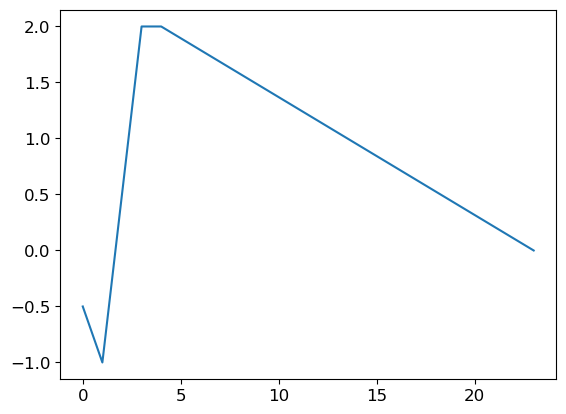

In [61]:
plt.plot(x)

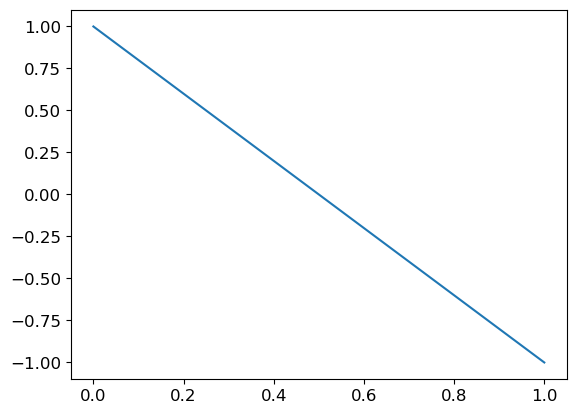

In [67]:
# kernel 1 only searches for the steep decrease
k1 = np.array([1, -1])
plt.plot(k1)

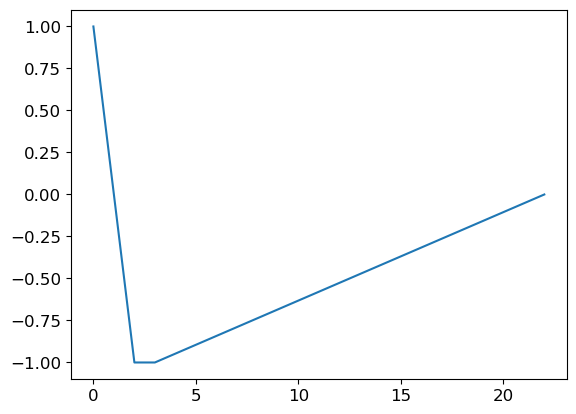

In [65]:
# kernel 2 is more custom and takes into account the steep decrease and slow recover
k2 = np.array([1, 0, -1] + list(np.linspace(-1, 0, 20)))
plt.plot(k2)

In [300]:
importlib.reload(artefact)
importlib.reload(resync)

<module 'functions.main_resync' from 'c:\\Users\\Juliette\\Research\\Projects\\Synchronization_project\\Code\\ReSync\\functions\\main_resync.py'>

In [15]:
#(LFP_df_offset, 
 #external_df_offset) = 

%matplotlib qt

resync.run_resync(
    LFP_array=LFP_array,
    lfp_sig=lfp_sig,
    LFP_rec_ch_names=LFP_rec_ch_names,
    external_file=external_file,
    BIP_channel=BIP_channel,
    external_rec_ch_names=external_rec_ch_names,
    SHOW_FIGURES = True
)

max: 422.4971860731
min: -372.061444697
mean: -0.009894282533127793
first_positive_peak: 1094, value: 352.8265278086
first_negative_peak: 1566, value: -293.1088207246
signal is inverted


In [ ]:
importlib.reload(plot)
importlib.reload(preproc)
importlib.reload(utils)
importlib.reload(artefact)
importlib.reload(crop)
importlib.reload(resync)

In [120]:
import json
from scipy.signal import find_peaks
from itertools import compress

In [121]:
def smooth_signal(data, window_size=3):
    smoothed_data = np.copy(data)
    half_window = window_size // 2
    
    for i in range(half_window, len(data) - half_window):
        smoothed_data[i] = np.mean(data[i - half_window : i + half_window + 1])
    
    return smoothed_data

In [122]:
def plot_LFP_artefact_channel(
    sub: str,
    timescale: np.ndarray,
    data: np.ndarray, 
    color: str,
    savingpath: str,
    saving_folder = True
):

    """
    Function that plots the selected intracerebral channel for quick visualization (and saving).

    Input:
        - sub: the subject ID
        - timescale: the timescale of the signal to be plotted (x)
        - data: single channel as np.ndarray (y)
        - color: the color of the signal on the plot
        - savingpath: the folder where the plot has to be saved
        - saving_folder: Boolean, default = True, plots are automatically saved

    """


    figure(figsize=(12, 6), dpi=80)
    plt.plot(data)
    #plt.scatter(timescale, data_diff, linewidth=1, color=color)
    plt.xlabel('Time (s)')
    plt.title(str(sub))
    plt.ylabel('Intracerebral LFP channel (µV)')

    if saving_folder:
        plt.savefig(savingpath + '\\Fig1-Intracerebral channel raw plot.png',bbox_inches='tight')



In [126]:
def find_LFP_sync_artefact(
    lfp_data: np.ndarray, 
    use_kernel: str = '1',
    consider_first_seconds_LFP=None,
):
    """
    Function that finds artefacts caused by
    augmenting-reducing stimulation from 0 to 1mA without ramp.
    For correct functioning, the LFP data should
    start in stim-off, and typically short pulses
    are given (without ramping).
    The function uses a kernel which mimics the stimulation-
    artefact. This kernel is multiplied with time-series
    snippets of the same length. If the time-serie is
    similar to the kernel, the dot-product is high, and this
    indicates a stim-artefact.

    Input:
        - lfp_data: single channel as np.ndarray (the function
            automatically inverts the signal if first a positive
            peak is found, this indicates an inverted signal)
        - use_kernel: decides whether kernel 1 or 2 is used,
            kernel 1 is straight-forward and finds a steep decrease,
            kernel 2 mimics the steep decrease and slow
            recovery of the signal. default is kernel 1.
        - consider_first_seconds_LFP: if given, only artefacts in the first
            (and last) n-seconds are considered
    
    Returns:
        - list of idx: a list with all stim-artefact starts. This
            also contains stim-artefacts not happening at the
            beginning or end of the recording. These have to be
            selected by the user afterwards (item.getter function).
    """
    #import settings
    json_path = os.path.join(os.getcwd(), 'config')
    json_filename = 'config.json'  # dont forget json extension
    with open(os.path.join(json_path, json_filename), 'r') as f:
        loaded_dict =  json.load(f)

    
    signal_inverted = False  # defaults false

    # checks correct input for use_kernel variable
    assert use_kernel in ['1', '2'], 'use_kernel incorrect'

    # kernel 1 only searches for the steep decrease
    # kernel 2 is more custom and takes into account the steep decrease and slow recover
    kernels = {'1': np.array([1, -1]),
               '2': np.array([1, 0, -1] + list(np.linspace(-1, 0, 20)))}
    ker = kernels[use_kernel]
    
    # get dot-products between kernel and time-serie snippets
    res = []  # store results of dot-products
    for i in np.arange(0, len(lfp_data) - len(ker)):
        res.append(ker @ lfp_data[i:i+len(ker)])  # calculate dot-product of vectors
        # the dot-product result is high when the timeseries snippet
        # is very similar to the kernel
    res = np.array(res)  # convert list to array

    # # normalise dot product results
    res = res / max(res)

    # calculate a ratio between std dev and maximum during
    # the first seconds to check whether an stim-artef was present 
    ratio_max_sd = np.max(res[:loaded_dict['sf_LFP']*30] / np.std(res[:loaded_dict['sf_LFP']*5]))
    
    # use peak of kernel dot products    
    pos_idx = find_peaks(x=res, height=.3 * max(res),
                        distance=loaded_dict['sf_LFP'])[0]
    neg_idx = find_peaks(x=-res, height=-.3 * min(res),
                        distance=loaded_dict['sf_LFP'])[0]

    # check whether signal is inverted
    if neg_idx[0] < pos_idx[0]:
        # the first peak should be POSITIVE (this is for the dot-product results)
        # actual signal is first peak negative
        # if NEG peak before POS then signal is inverted
        print('signal is inverted')
        signal_inverted = True
        #print(pos_idx[0], neg_idx[0])
        # re-check inverted for difficult cases with small pos-lfp peak before negative stim-artefact
        if (pos_idx[0] - neg_idx[0]) < 50:  # if first positive and negative are very close
            width_pos = 0
            r_i = pos_idx[0]
            while res[r_i] > (max(res) * .3):
                r_i += 1
                width_pos += 1
            width_neg = 0
            r_i = neg_idx[0]
            while res[r_i] < (min(res) * .3):
                r_i += 1
                width_neg += 1
            # undo invertion if negative dot-product (pos lfp peak) is very narrow
            if width_pos > (2 * width_neg):
                signal_inverted = False
                print('invertion undone')
            
           
    # return either POS or NEG peak-indices based on normal or inverted signal
    if not signal_inverted:
        stim_idx = pos_idx  # this is for 'normal' signal

    elif signal_inverted:
        stim_idx = neg_idx

    

    # check warn if NO STIM artefacts are suspected
    if len(stim_idx) > 20 and ratio_max_sd < 8:
        print('WARNING: probably the LFP signal did NOT'
              ' contain any artefacts. Many incorrect timings'
              ' could be returned')


    if consider_first_seconds_LFP:
        border_start = loaded_dict['sf_LFP']*consider_first_seconds_LFP
        border_end = len(lfp_data) - (loaded_dict['sf_LFP'] * consider_first_seconds_LFP)
        sel = np.logical_or(np.array(stim_idx) < border_start,
                             np.array(stim_idx) > border_end)
        stim_idx = list(compress(stim_idx, sel))

    """
    # filter out inconsistencies in peak heights (assuming sync-stim-artefacts are stable)
    abs_heights = [max(abs(lfp_data[i-5:i+5])) for i in stim_idx]
    diff_median = np.array([abs(p - np.median(abs_heights)) for p in abs_heights])
    sel_idx = diff_median < (np.median(abs_heights) * .66)
    stim_idx = list(compress(stim_idx, sel_idx))
    # check polarity of peak
    if not signal_inverted:
        sel_idx = np.array([min(lfp_data[i-5:i+5]) for i in stim_idx]) < (np.median(abs_heights) * -.5)
    elif signal_inverted:
        sel_idx = np.array([max(lfp_data[i-5:i+5]) for i in stim_idx])  > (np.median(abs_heights) * .5)
    stim_idx = list(compress(stim_idx, sel_idx))
    """

    return stim_idx

In [153]:
# import settings
json_path = os.path.join(os.getcwd(), 'config')
json_filename = 'config.json'  # dont forget json extension
with open(os.path.join(json_path, json_filename), 'r') as f:
    loaded_dict =  json.load(f)

# check that the subject ID has been entered properly in the config file:
if loaded_dict['subject_ID'] is None or loaded_dict['subject_ID'] == "":
    raise ValueError('Please fill in the subject_ID in the config file as a str')

# set saving path
if loaded_dict['saving_path'] == False:
    saving_path = utils.define_folders()
else:
    saving_path = os.path.join(os.path.normpath(loaded_dict['saving_path']), loaded_dict['subject_ID'])
    if not os.path.isdir(saving_path):
        os.makedirs(saving_path)

# Generate timescales:
LFP_timescale_s = np.arange(0,(len(lfp_sig)/loaded_dict['sf_LFP']),(1/loaded_dict['sf_LFP']))

smoothed_signal = smooth_signal(lfp_sig, window_size=5)

# PLOT 1 : plot the signal of the channel used for artefact detection in intracerebral recording:
plot_LFP_artefact_channel(loaded_dict['subject_ID'], 
                                LFP_timescale_s, 
                                smoothed_signal, 'darkorange', 
                                savingpath = saving_path)

### DETECT ARTEFACTS ###

# find artefacts in intracerebral channel
art_idx_LFP = find_LFP_sync_artefact(
    smoothed_signal,
    use_kernel=loaded_dict['kernel'], 
    consider_first_seconds_LFP=loaded_dict['consider_first_seconds_LFP']
)

art_time_LFP = utils.convert_index_to_time(art_idx_LFP,
                                            loaded_dict['sf_LFP']) 

# PLOT 3 : plot the intracerebral channel with its artefacts detected:
plot.plot_channel(loaded_dict['subject_ID'], 
                    LFP_timescale_s, 
                    smoothed_signal,
                    'darkorange',scatter=True)
plt.ylabel('Intracerebral LFP channel (µV)')
for xline in art_time_LFP:
    plt.axvline(x=xline, 
                ymin=min(lfp_sig), 
                ymax=max(lfp_sig), 
                color='black', 
                linestyle='dashed',
                alpha=.3,)



# PLOT 4 : plot the first artefact detected in intracerebral channel for verification of sample choice:
plot.plot_channel(loaded_dict['subject_ID'], 
                    LFP_timescale_s, 
                    smoothed_signal, 'darkorange',
                    scatter=True)
plt.ylabel('Intracerebral LFP channel (µV)')
for xline in art_time_LFP:
    plt.axvline(x=xline, 
                ymin=min(lfp_sig), 
                ymax=max(lfp_sig), 
                color='black', 
                linestyle='dashed', 
                alpha=.3,)
plt.xlim(art_time_LFP[0]-0.1,art_time_LFP[0]+0.3)


signal is inverted


(6.056, 6.4559999999999995)

## PART 3 : Look for timeshift ##

In [ ]:
resync.run_timeshift_analysis(
    LFP_df_offset,
    external_df_offset,
    SHOW_FIGURES = True
)


## PART 4 : Look for packet loss ##

In [ ]:
json_fname = 'Report_Json_Session_Report_20230523T113952.json'  ## write json filename with extension
sub = '047'
resync.check_packet_loss(json_fname, sub)

## PLAYGROUND ##

##### ECG artefact verification #####

In [16]:
importlib.reload(resync)

<module 'functions.main_resync' from 'c:\\Users\\Juliette\\Research\\Projects\\Synchronization_project\\Code\\ReSync\\functions\\main_resync.py'>

In [ ]:
resync.ecg(LFP_df_offset,
    external_df_offset,
    SHOW_FIGURES = True
)

##### Make quick figures #####

In [ ]:
import json

#import settings
json_path = os.path.join(os.getcwd(), 'config')
json_filename = 'config.json'  # dont forget json extension
with open(os.path.join(json_path, json_filename), 'r') as f:
    loaded_dict =  json.load(f)

#set saving path
if loaded_dict['saving_path'] == False:
    saving_path = utils.define_folders()
else:
    saving_path = os.path.join(os.path.normpath(loaded_dict['saving_path']), loaded_dict['subject_ID'])
    if not os.path.isdir(saving_path):
        os.makedirs(saving_path)


### DETECT ARTEFACTS ###

# Reselect artefact channels in the aligned (= cropped) files
LFP_channel_offset = LFP_df_offset.iloc[:,loaded_dict['LFP_ch_index']].to_numpy()  
BIP_channel_offset = external_df_offset.iloc[:,loaded_dict['BIP_ch_index']].to_numpy() 

# Generate new timescales:
LFP_timescale_offset_s = np.arange(0,(len(LFP_channel_offset)/loaded_dict['sf_LFP']),1/loaded_dict['sf_LFP'])
external_timescale_offset_s = np.arange(0,(len(BIP_channel_offset)/loaded_dict['sf_external']),1/loaded_dict['sf_external'])

filtered_external_offset = preproc.filtering(BIP_channel_offset)

In [ ]:
# Both signals aligned with all their artefacts detected:
fig, (ax1, ax2) = plt.subplots(2,1)
fig.suptitle(str(loaded_dict['subject_ID']))
fig.set_figheight(6)
fig.set_figwidth(12)
ax1.axes.xaxis.set_ticklabels([])
ax2.set_xlabel('Time (s)')
ax1.set_ylabel('Intracerebral LFP channel (µV)')
ax2.set_ylabel('External bipolar channel (mV)')
#ax1.set_xlim(0,len(LFP_channel_offset)/loaded_dict['sf_LFP']) 
#ax2.set_xlim(0,len(LFP_channel_offset)/loaded_dict['sf_LFP']) 
ax1.set_xlim(264.9,265.4) 
ax2.set_xlim(264.9,265.4)
ax1.set_ylim(-500,500)
ax1.scatter(LFP_timescale_offset_s,LFP_channel_offset,color='darkorange',zorder=1, s=3)
ax2.plot(external_timescale_offset_s,filtered_external_offset, color='darkcyan',zorder=1, linewidth=0.1) 

fig.savefig(saving_path + '\\last artefact zoomed.png',bbox_inches='tight')


In [ ]:
plt.scatter(LFP_timescale_offset_s,LFP_channel_offset,color='darkorange',zorder=1, s=5)
plt.title(str(loaded_dict['subject_ID']))
plt.xlim(265,265.4)
plt.ylim(-400,200)
plt.xlabel('Time (s)')
plt.ylabel('Intracerebral LFP channel (µV)')
plt.savefig(saving_path + '\\last artefact zoomed2.png',bbox_inches='tight')